In [1]:
# !pip3 install yfinance

In [2]:
# Assignment 1 for MFE407
# Author: Ashutosh Ekade

## Assignment 1
The goal of this assignment is to write a simple back-testing algorithm. It is not a test for you to come up with new strategies. 
I have laid out all the instructions. ChatGPT is the best friend in coding. 
P.S. if this is too easy, happy to give your more difficult tasks:-) 

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import matplotlib.pyplot as plt
from random import sample

#### Read in NYSE.txt into a DataFrame, which includes stock tickers and names


In [4]:
#read the stock tickers and names into a DataFrame
df = pd.read_csv('~/Downloads/NYSE.txt', sep='\t', header=0) ## please ensure that the file NYSE.txt is as the same location as mentioned here.
#Create a list contains all tickers: iterate through stock list and append tickers into an empty list
all_tickers_list = df.Symbol.to_list()

#### Using one stock as an example to construct buy-sell strategy 

Step 1: Download data and calculate necessary summary statistics

In [5]:
#download stock data for the FIRST stock and place in DataFrame (using yf.download)
first_stock_data = yf.download(all_tickers_list[0])
print(type(first_stock_data))

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>


In [6]:
#create column to hold our 90 day rolling standard deviation 
# print(first_stock_data.head(5))
first_stock_data['90_SD'] = first_stock_data['Adj Close'].rolling(90).std()
# print(first_stock_data.head(-10))

In [7]:
#create a column to hold our 20 day moving average 
first_stock_data['20_MA'] = first_stock_data['Adj Close'].rolling(20).mean()

Step 2: Create "BUY" signal according to two conditions

In [8]:
#BUY Condition 1: create a column which holds a TRUE value if the gap down from previous day's low to next day's open is larger than the 90 day rolling HALF of standard deviation

first_stock_data['Cond_1'] =  np.where((first_stock_data['Low'].shift(1) - first_stock_data['Open']) > (0.5*first_stock_data['90_SD']), True, False)
print("Condition 1 was satisfied {} times.".format(first_stock_data['Cond_1'].sum()))

Condition 1 was satisfied 28 times.


In [9]:
#BUY Condition 2: create a column which holds a TRUE value if the opening price of the stock is above the 20 day moving average 
first_stock_data['Cond_2'] =  np.where(first_stock_data['Open'] > first_stock_data['20_MA'], True, False)
print("Condition 2 was satisfied {} times.".format(first_stock_data['Cond_2'].sum()))

Condition 2 was satisfied 5522 times.


In [10]:
#"BUY" signal: create a column that holds a TRUE value if both buy criteria are also TRUE
first_stock_data['signal'] =  np.where((first_stock_data['Cond_1'] == True) & (first_stock_data['Cond_2'] == True), True, False)
print("Buy signal {} times.".format(first_stock_data['signal'].sum()))

Buy signal 15 times.


Step 3: Create "SELL" signal according to two conditions

In [11]:
#SELL Condition 1: create a column which holds a TRUE value if the gap up from previous day's high to next day's open is larger than the 90 day rolling HALF of standard deviation
first_stock_data['Sell_Cond_1'] =  np.where((first_stock_data['Open'] - first_stock_data['High'].shift(1)) > (0.5*first_stock_data['90_SD']), True, False)
print("Sell condition 1 was satisfied {} times.".format(first_stock_data['Sell_Cond_1'].sum()))

Sell condition 1 was satisfied 32 times.


In [12]:
#SELL Condition 2: create a column which holds a TRUE value if the opening price of the stock is below the 20 day moving average
first_stock_data['Sell_Cond_2'] =  np.where(first_stock_data['Open'] < first_stock_data['20_MA'], True, False)
print("Sell condition 2 was satisfied {} times.".format(first_stock_data['Sell_Cond_2'].sum()))

Sell condition 2 was satisfied 539 times.


In [13]:
#"SELL" signal: create a column that holds a TRUE value if both sell criteria are also TRUE
first_stock_data['sell_signal'] =  np.where((first_stock_data['Sell_Cond_1'] == True) & (first_stock_data['Sell_Cond_2'] == True), True, False)
print("Sell signal {} times.".format(first_stock_data['sell_signal'].sum()))

Sell signal 0 times.


Step 4: Show the results of Trading Algo

In [14]:
#calculate daily % return series for stock
first_stock_data['daily_returns'] = first_stock_data['Adj Close'].pct_change()

##### A Chanllenge: create an indicator which equals to 1 if you hold one share and to -1 if you sell one share. 
As a example, if at day 10, the algo tells you to buy a share, and at day 15, the algo tells you to sell a share, then you do not hold any share from day 1 to day 10, and hold one share form day 11 to day 15, and short-sell a share from day 16. How can you constrcut such an indicator in the dataset? 

Step 1: Calculate shares of holding for each day

In [15]:
# Create a column contains your holding of shares according to "BUY" and "SELL" signals you created in previous steps
# first_stock_data['Share'] = np.where(first_stock_data["signal"]==True, 1, np.where(first_stock_data["sell_signal"]==True, -1, 0))
buy_indices = first_stock_data[first_stock_data['signal']==True].index
sell_indices = first_stock_data[first_stock_data['sell_signal']==True].index
indicator = []
sig_to_append = 0
for idx in first_stock_data.index:
    if idx in buy_indices:
        sig_to_append = 1
    elif idx in sell_indices:
        sig_to_append = -1
    else:
         pass
    indicator.append(sig_to_append)
first_stock_data['Share'] = indicator

In [16]:
# Verify. The new column is "Share" (verificaiton is an important step to check whether your previous implementation is correct.)
first_stock_data[['daily_returns', 'signal', 'sell_signal', 'Share']][4218:4222]

,daily_returns,signal,sell_signal,Share
Date,,,,
2016-08-25,0.011991,False,False,1
2016-08-26,0.001270,False,False,1
2016-08-29,0.006340,False,False,1
2016-08-30,-0.010080,False,False,1


In [17]:
print(first_stock_data["Share"].value_counts())

Share
1    4828
0    1252
Name: count, dtype: int64


Step 2: Calculate strategic returns according to your holdings of shares and daily stock returns

In [18]:
#create a strategy return series by using the daily stock returns mutliplied by 1 if we are long and -1 if we are short
first_stock_data['Rets'] = first_stock_data['daily_returns'] * first_stock_data['Share']

In [19]:
# Verify again
first_stock_data[['daily_returns', 'signal', 'sell_signal', 'Share', 'Rets']][4218:4222]

,daily_returns,signal,sell_signal,Share,Rets
Date,,,,,
2016-08-25,0.011991,False,False,1,0.011991
2016-08-26,0.001270,False,False,1,0.001270
2016-08-29,0.006340,False,False,1,0.006340
2016-08-30,-0.010080,False,False,1,-0.010080


#### Good Job! Apply the strategy to all stocks in stocks_list

In [20]:
#create empty list to hold our return series DataFrame for each stock
frames = []
# lets randomly select 200 stocks from the list
sample_stocks = sample(all_tickers_list, 200)
for stock in sample_stocks:
    try:
        ### Copy Paste Previous Code For One Stock ###
        first_stock_data = yf.download(stock)
        first_stock_data['90_SD'] = first_stock_data['Adj Close'].rolling(90).std()
        first_stock_data['20_MA'] = first_stock_data['Adj Close'].rolling(20).mean()
        first_stock_data['Cond_1'] =  np.where((first_stock_data['Low'].shift(1) - first_stock_data['Open']) > (0.5*first_stock_data['90_SD']), True, False)
        first_stock_data['Cond_2'] =  np.where(first_stock_data['Open'] > first_stock_data['20_MA'], True, False)
        first_stock_data['signal'] =  np.where((first_stock_data['Cond_1'] == True) & (first_stock_data['Cond_2'] == True), True, False)
        first_stock_data['Sell_Cond_1'] =  np.where((first_stock_data['Open'] - first_stock_data['High'].shift(1)) > (0.5*first_stock_data['90_SD']), True, False)
        first_stock_data['Sell_Cond_2'] =  np.where(first_stock_data['Open'] < first_stock_data['20_MA'], True, False)
        first_stock_data['sell_signal'] =  np.where((first_stock_data['Sell_Cond_1'] == True) & (first_stock_data['Sell_Cond_2'] == True), True, False)
        first_stock_data['daily_returns'] = first_stock_data['Adj Close'].pct_change()
        buy_indices = first_stock_data[first_stock_data['signal']==True].index
        sell_indices = first_stock_data[first_stock_data['sell_signal']==True].index
        indicator = []
        sig_to_append = 0
        for idx in first_stock_data.index:
            if idx in buy_indices:
                sig_to_append = 1
            elif idx in sell_indices:
                sig_to_append = -1
            else:
                pass
            indicator.append(sig_to_append)
        first_stock_data['Share'] = indicator
        first_stock_data['Rets'] = first_stock_data['daily_returns'] * first_stock_data['Share']
        #append the strategy return series to our list
        frames.append(first_stock_data['Rets'])
    except:
        pass

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SBGL']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Failed to get ticker 'WRI' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Read timed out. (read timeout=10)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['WRI']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SNR']: Exception('%ticker%: No timezone found, 

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JTD']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SAN-I']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['MS-K']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DUC']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DNI']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%*****************

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GS-N']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CBS.A']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ELJ']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TOO-A']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['OKS']: Exception('%ticker%: No price data fou

#### Plot cummulative returns of strategy 
Step 1: Calculate cumulative returns 

In [21]:
#concatenate the individual DataFrames held in our list- and do it along the column axis
new_df = pd.concat(frames, ignore_index=False, axis=1, keys=sample_stocks)

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_78967/3577510563.py:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  new_df = pd.concat(frames, ignore_index=False, axis=1, keys=sample_stocks)


In [22]:
#create a column to hold the sum of all the individual daily strategy returns
new_df['daily_returns_sum'] = new_df.sum(axis=1, numeric_only=True)

In [23]:
#fill 'NaNs' with zeros to allow our "count" function below to work properly
print(new_df.daily_returns_sum.sum())

360.6408758736099


In [24]:
#create a column that hold the count of the number of stocks that were traded each day
#we minus one from it so that we dont count the "Total" column we added as a trade.
new_df['count'] = new_df.count(axis=1)


In [25]:
print(new_df.head())

            MLR  NYRT  AGI  SBGL  SLB  RY  GFA  WRI  SNR  DFIN  ...  CDR  \
Date                                                            ...        
1966-07-05  NaN   NaN  NaN   NaN  NaN NaN  NaN  NaN  NaN   NaN  ...  NaN   
1966-07-06  NaN   NaN  NaN   NaN  NaN NaN  NaN  NaN  NaN   NaN  ...  NaN   
1966-07-07  NaN   NaN  NaN   NaN  NaN NaN  NaN  NaN  NaN   NaN  ...  NaN   
1966-07-08  NaN   NaN  NaN   NaN  NaN NaN  NaN  NaN  NaN   NaN  ...  NaN   
1966-07-11  NaN   NaN  NaN   NaN  NaN NaN  NaN  NaN  NaN   NaN  ...  NaN   

            AFS-D  MIT-B  LDP  UN  NQP  IEX  MP-D  daily_returns_sum  count  
Date                                                                         
1966-07-05    NaN    NaN  NaN NaN  NaN  NaN   NaN                0.0      1  
1966-07-06    NaN    NaN  NaN NaN  NaN  NaN   NaN                0.0      2  
1966-07-07    NaN    NaN  NaN NaN  NaN  NaN   NaN                0.0      2  
1966-07-08    NaN    NaN  NaN NaN  NaN  NaN   NaN                0.0      2  

In [26]:
#create a column that divides the "total" strategy return each day by the number of stocks traded that day to get equally weighted return.
new_df['daily_equally_wt_returns'] = new_df['daily_returns_sum'] / new_df['count']

Step 2: Plot 

<Axes: xlabel='Date', ylabel='strategy daily returns %'>

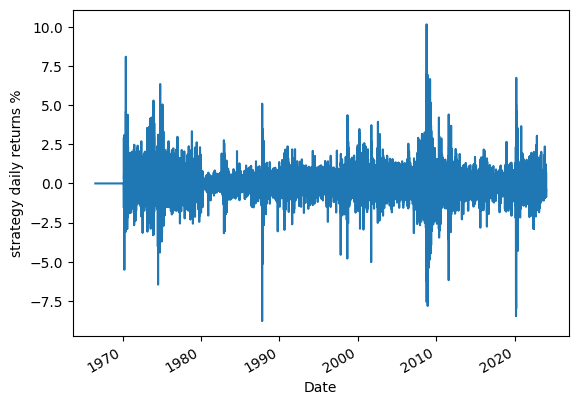

In [27]:
#plot the strategy returns
(new_df['daily_equally_wt_returns'] * 100).plot(ylabel="strategy daily returns %")

<Axes: xlabel='Date', ylabel='equity curve for $100 starting capital'>

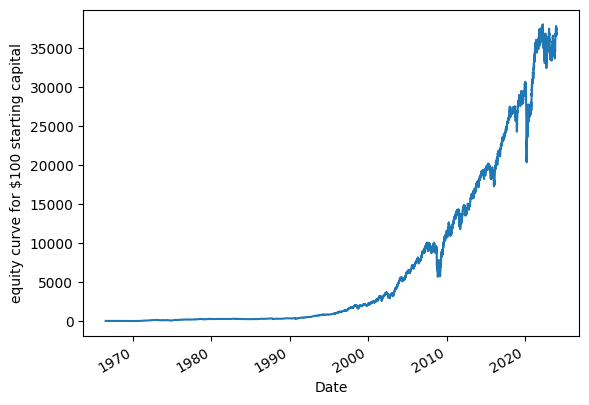

In [28]:
new_df['daily_cum_returns'] = (1 + new_df['daily_equally_wt_returns']).cumprod() - 1
(new_df['daily_cum_returns'] * 100).plot(ylabel="equity curve for $100 starting capital")

Step 3: Calculate annual returns and sharpe ratio for your strategy

In [29]:
# Annual Return 
annual_returns = new_df['daily_equally_wt_returns'].mean() * 255
print("Annual returns of the strategy are {:.2f} %".format(annual_returns*100))

Annual returns of the strategy are 11.33 %


In [30]:
# Sharpe Ratio (risk free element excluded for simplicity)
def sharpe(returns):
    ann = returns.mean() * 255
    std_dev_ann = returns.std() * np.sqrt(255)
    return ann / std_dev_ann

strat_sharpe = sharpe(new_df['daily_equally_wt_returns'])
print("Strategy sharpe ratio is {:.2f}".format(strat_sharpe))

Strategy sharpe ratio is 0.84


#### Congraduation!!! You have written the first backtesting code yourself!!! 